# Exploring MIMIC-III

Let's begin by exploring data in the MIMIC-III Waveform Database.

Our **objectives** are to:
- Become familiar with the file structure
- Find out which signals are present in selected records and segments, and how long the signals last.
- Search for records that contain signals of interest.
- Load waveforms using the WFDB toolbox.
- Plot one minute of signals from a segment of data
- Look more closely at the shape of the PPG pulse waves

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the MIMIC-III Waveform Database <a href="https://physionet.org/content/mimic3wdb/1.0/">here</a>.</p>
</div>

---
## Setup

### Specify the required Python packages
We'll import the following:
- _sys_: an essential python package
- _pathlib_ (well a particular function from _pathlib_, called _Path_)

In [188]:
import sys
from pathlib import Path

### Specify a particular version of the WFDB Toolbox

- _wfdb_: For this workshop we will be using version 4 of the WaveForm DataBase (WFDB) Toolbox package. The package contains tools for processing waveform data such as those found in MIMIC:

In [ ]:
!pip install wfdb==4.1.0
import wfdb

<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the WFDB package <a href="https://physionet.org/content/wfdb-python/3.4.1/">here</a>.</p>
</div>

Now that we have imported these packages (_i.e._ toolboxes) we have a set of tools (functions) ready to use.

### Specify the name of the MIMIC Waveform Database

- Specify the name of the MIMIC-III Matched Waveform Database on Physionet, which comes from the URL: https://physionet.org/content/mimic3wdb-matched/1.0/

In [190]:
database_name = 'mimic3wdb-matched/1.0'

---
## Identify the records in the database

### Get a list of records

- Use the [`get_record_list`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.get_record_list) function from the WFDB toolbox to get a list of records in the database.

In [191]:
icustay_records = wfdb.get_record_list(database_name)
print("Done: Loaded list of {} ICU stays for '{}' database".format(len(icustay_records), database_name))

Done: Loaded list of 10282 ICU stays for 'mimic3wdb-matched/1.0' database


- Display the first few records

In [192]:
print("First five ICU stays: {}".format(icustay_records[0:5]))

First five ICU stays: ['p00/p000020/', 'p00/p000030/', 'p00/p000033/', 'p00/p000052/', 'p00/p000079/']


Note the formatting of these records: each starts with an intermediate directory ("p00" in this case), followed by a record directory.

<div class="alert alert-block alert-info"> <b>Q:</b> Can you print the names of the last five ICU stays? <br> <b>Hint:</b> in Python, the last five elements can be specified using '[-5:]' </div>

In [193]:
# iterate the subjects to get a list of records
max_records_to_load = 100
records = []
for subject in icustay_records:
    # stop if we've loaded enough records
    if len(records) >= max_records_to_load:
        print("Reached maximum required number of records.")
        break
    studies = wfdb.get_record_list(f'{database_name}/{subject}')
    for study in studies:
        records.append(Path(f'{subject}{study}'))

print(f"Loaded {len(records)} records from the '{database_name}' database.")

Reached maximum required number of records.
Loaded 106 records from the 'mimic3wdb-matched/1.0' database.


### Look at the records

- Display the first few records

In [194]:
# format and print first five records
first_five_records = [str(x) for x in records[2:7]]  # ignored the first two which are numerics
first_five_records = "\n - ".join(first_five_records)
print(f"First five records: \n - {first_five_records}")

print("""
Note the formatting of these records:
 - intermediate directory ('p00' in this case)
 - icu stay identifier (e.g. 'p000020')
 - segment identifier (e.g. '3544749_0001'), consisting of the record (e.g. '3544749'), followed by the segment number (e.g. '0001').
 """)

First five records: 
 - p00/p000020/3544749_0001
 - p00/p000020/3544749_0002
 - p00/p000020/3544749_0003
 - p00/p000020/3544749_0004
 - p00/p000020/3544749_0005

Note the formatting of these records:
 - intermediate directory ('p00' in this case)
 - icu stay identifier (e.g. 'p000020')
 - segment identifier (e.g. '3544749_0001'), consisting of the record (e.g. '3544749'), followed by the segment number (e.g. '0001').
 


<div class="alert alert-block alert-info">
<p><b>Q:</b> Can you print the names of the last five records? <br> <b>Hint:</b> in Python, the last five elements can be specified using '[-5:]'</p>
</div>

## Identify records suitable for analysis

- The signals and their durations vary from one record (and segment) to the next. 
- Since most studies require specific types of signals (e.g. blood pressure and photoplethysmography signals), we need to be able to identify which records (or segments) contain the required signals and duration.

### Setup

In [195]:
import pandas as pd
from pprint import pprint

In [196]:
print(f"Earlier, we loaded {len(icustay_records)} records from the '{database_name}' database.")

Earlier, we loaded 10282 records from the 'mimic3wdb-matched/1.0' database.


### Specify requirements

- Required signals

In [197]:
required_sigs = ['ABP', 'PLETH', 'II']

_Definitions:_
- ABP - arterial blood presure (i.e. blood pressure signal)
- PLETH - photoplethysmogram (PPG) signal
- II - lead II electrocardiogram (ECG) signal

- Required duration

In [198]:
# convert from minutes to seconds
req_seg_duration = 10*60 

### Find out how many records meet the requirements

_NB: This step may take a while. The results are copied below to save running it yourself._

In [ ]:
import urllib.request # to read online text file

no_recs_req = 100
matching_recs = {'dir':[], 'seg_name':[], 'length':[]}

for icustay_record in icustay_records:
    
    if len(matching_recs['seg_name']) == no_recs_req:
        break
    
    print('Record: {}'.format(icustay_record)) #, end="", flush=True)
    icustay_record_dir = f'{database_name}/{icustay_record}'
    temp = icustay_record.split("/")
    icustay_record_name = temp[1]
    
    print(' Identifying segments: ', end="", flush=True)  
    target_url = "https://physionet.org/files/" + icustay_record_dir + "RECORDS"
    data = urllib.request.urlopen(target_url)
    
    segs = []
    for line in data:
        curr_line = line.decode("utf-8") 
        if "p" not in curr_line:
            temp = curr_line.split("\n")
            segs.append(temp[0])
    
    # check to see whether there are any waveform files (as opposed to just numerics)
    if len(segs) == 0:
        print('(no waveforms)')
        continue
    
    # check to see whether the required signals are present in this recording
    rec_header = segs[0].split("_")[0] + "_layout"
    rec_metadata = wfdb.rdheader(rec_header,
                                pn_dir=icustay_record_dir,
                                rd_segments=True)
    sigs_present = rec_metadata.sig_name
    if not all(x in sigs_present for x in required_sigs):
        print('{} (missing signals)'.format(rec_header))
        continue
            
    print(' Reading data: ', end="", flush=True)
    for seg in segs:
        print(seg, end="", flush=True)
        seg_metadata = wfdb.rdheader(seg,
                                pn_dir=icustay_record_dir,
                                rd_segments=True)

        # Check whether the required signals are present in this segment
        sigs_present = seg_metadata.sig_name
        if not all(x in sigs_present for x in required_sigs):
            print('   (missing signals)')
            continue
        
        # Check whether the segment is of the required duration
        seg_length = seg_metadata.sig_len/(seg_metadata.fs)

        req_seg_duration = 60*10
        if seg_length < req_seg_duration:
            print(f' (too short at {seg_length/60:.1f} mins)')
            continue

        matching_recs['dir'].append(icustay_record_dir)
        matching_recs['seg_name'].append(seg)
        matching_recs['length'].append(seg_length)
        print(' (met requirements)')
        # Since we only need one segment per record break out of loop
        break

print(f"A total of {len(matching_recs['dir'])} records met the requirements:")

#df_matching_recs = pd.DataFrame(data=matching_recs)
#df_matching_recs.to_csv('matching_records.csv', index=False)
#p=1

In [213]:
print(f"A total of {len(matching_recs['dir'])} records were identified that met the requirements (although the search was limited to {no_recs_req} records).")

relevant_segments_names = "\n - ".join(matching_recs['seg_name'])
print(f"\nThe relevant segment names are:\n - {relevant_segments_names}")

relevant_dirs = "\n - ".join(matching_recs['dir'])
print(f"\nThe corresponding directories are: \n - {relevant_dirs}")

A total of 100 records were identified that met the requirements (although the search was limited to 100 records).

The relevant segment names are:
 - 3531764_0003
 - 3285727_0007
 - 3092245_0007
 - 3047369_0003
 - 3481389_0008
 - 3189254_0006
 - 3054941_0001
 - 3462211_0001
 - 3755731_0015
 - 3988865_0012
 - 3747397_0005
 - 3016830_0019
 - 3429844_0002
 - 3395556_0005
 - 3046879_0003
 - 3376064_0010
 - 3205611_0013
 - 3126291_0001
 - 3622493_0043
 - 3410222_0004
 - 3021418_0002
 - 3832863_0007
 - 3757068_0002
 - 3090785_0011
 - 3929725_0001
 - 3031688_0022
 - 3040472_0001
 - 3289928_0011
 - 3068462_0004
 - 3873015_0004
 - 3089709_0002
 - 3883443_0015
 - 3447276_0006
 - 3216751_0009
 - 3377083_0005
 - 3831833_0006
 - 3203448_0022
 - 3729471_0009
 - 3000714_0001
 - 3019875_0004
 - 3113048_0001
 - 3678945_0003
 - 3358389_0004
 - 3124300_0001
 - 3145678_0005
 - 3383991_0003
 - 3147138_0008
 - 3068585_0032
 - 3545143_0009
 - 3062663_0002
 - 3548704_0010
 - 3947427_0006
 - 3763138_0005
 - 3

<div class="alert alert-block alert-info">
<p><b>Question:</b> Is this enough data for a study? Consider different types of studies, e.g. assessing the performance of a previously proposed algorithm to estimate BP from the PPG signal, vs. developing a deep learning approach to estimate BP from the PPG.</p>
</div>

## Extract data for a segment

- Provide a list of segments which meet the requirements for the study

In [214]:
segment_names = ['3531764_0003', '3285727_0007', '3092245_0007', '3047369_0003', '3481389_0008', '3189254_0006', '3054941_0001', '3462211_0001', '3755731_0015', '3988865_0012', '3747397_0005', '3016830_0019', '3429844_0002', '3395556_0005', '3046879_0003', '3376064_0010', '3205611_0013', '3126291_0001', '3622493_0043', '3410222_0004', '3021418_0002', '3832863_0007', '3757068_0002', '3090785_0011', '3929725_0001', '3031688_0022', '3040472_0001', '3289928_0011', '3068462_0004', '3873015_0004', '3089709_0002', '3883443_0015', '3447276_0006', '3216751_0009', '3377083_0005', '3831833_0006', '3203448_0022', '3729471_0009', '3000714_0001', '3019875_0004', '3113048_0001', '3678945_0003', '3358389_0004', '3124300_0001', '3145678_0005', '3383991_0003', '3147138_0008', '3068585_0032', '3545143_0009', '3062663_0002', '3548704_0010', '3947427_0006', '3763138_0005', '3263629_0001', '3081334_0026', '3251540_0009', '3195697_0001', '3973217_0001', '3942161_0001', '3696733_0005', '3176657_0041', '3310335_0019', '3132214_0015', '3228071_0003', '3195753_0006', '3573743_0005', '3266729_0003', '3760919_0010', '3958352_0006', '3300295_0003', '3028261_0046', '3912316_0020', '3341288_0003', '3306238_0001', '3217364_0003', '3872162_0001', '3133443_0001', '3457114_0003', '3020774_0012', '3820075_0003', '3573275_0029', '3145453_0019', '3528521_0005', '3119460_0009', '3511654_0003', '3061470_0003', '3083615_0012', '3145814_0005', '3426164_0003', '3688103_0007', '3228082_0010', '3028253_0056', '3523904_0009', '3576649_0004', '3794019_0005', '3013677_0009', '3025436_0007', '3879187_0012', '3195265_0024', '3163704_0001']
segment_dirs = ['mimic3wdb-matched/1.0/p00/p000160/', 'mimic3wdb-matched/1.0/p00/p000188/', 'mimic3wdb-matched/1.0/p00/p000333/', 'mimic3wdb-matched/1.0/p00/p000543/', 'mimic3wdb-matched/1.0/p00/p000618/', 'mimic3wdb-matched/1.0/p00/p000735/', 'mimic3wdb-matched/1.0/p00/p000801/', 'mimic3wdb-matched/1.0/p00/p000946/', 'mimic3wdb-matched/1.0/p00/p001038/', 'mimic3wdb-matched/1.0/p00/p001049/', 'mimic3wdb-matched/1.0/p00/p001457/', 'mimic3wdb-matched/1.0/p00/p001501/', 'mimic3wdb-matched/1.0/p00/p001606/', 'mimic3wdb-matched/1.0/p00/p001791/', 'mimic3wdb-matched/1.0/p00/p001840/', 'mimic3wdb-matched/1.0/p00/p001855/', 'mimic3wdb-matched/1.0/p00/p001949/', 'mimic3wdb-matched/1.0/p00/p002063/', 'mimic3wdb-matched/1.0/p00/p002343/', 'mimic3wdb-matched/1.0/p00/p002369/', 'mimic3wdb-matched/1.0/p00/p002458/', 'mimic3wdb-matched/1.0/p00/p002577/', 'mimic3wdb-matched/1.0/p00/p002586/', 'mimic3wdb-matched/1.0/p00/p002639/', 'mimic3wdb-matched/1.0/p00/p002703/', 'mimic3wdb-matched/1.0/p00/p002858/', 'mimic3wdb-matched/1.0/p00/p002906/', 'mimic3wdb-matched/1.0/p00/p002974/', 'mimic3wdb-matched/1.0/p00/p002981/', 'mimic3wdb-matched/1.0/p00/p003039/', 'mimic3wdb-matched/1.0/p00/p003386/', 'mimic3wdb-matched/1.0/p00/p003617/', 'mimic3wdb-matched/1.0/p00/p003744/', 'mimic3wdb-matched/1.0/p00/p003866/', 'mimic3wdb-matched/1.0/p00/p003949/', 'mimic3wdb-matched/1.0/p00/p004053/', 'mimic3wdb-matched/1.0/p00/p004115/', 'mimic3wdb-matched/1.0/p00/p004313/', 'mimic3wdb-matched/1.0/p00/p004324/', 'mimic3wdb-matched/1.0/p00/p004331/', 'mimic3wdb-matched/1.0/p00/p004405/', 'mimic3wdb-matched/1.0/p00/p004588/', 'mimic3wdb-matched/1.0/p00/p004679/', 'mimic3wdb-matched/1.0/p00/p004802/', 'mimic3wdb-matched/1.0/p00/p004804/', 'mimic3wdb-matched/1.0/p00/p004833/', 'mimic3wdb-matched/1.0/p00/p004837/', 'mimic3wdb-matched/1.0/p00/p004904/', 'mimic3wdb-matched/1.0/p00/p004906/', 'mimic3wdb-matched/1.0/p00/p004966/', 'mimic3wdb-matched/1.0/p00/p005030/', 'mimic3wdb-matched/1.0/p00/p005071/', 'mimic3wdb-matched/1.0/p00/p005193/', 'mimic3wdb-matched/1.0/p00/p005345/', 'mimic3wdb-matched/1.0/p00/p005453/', 'mimic3wdb-matched/1.0/p00/p005742/', 'mimic3wdb-matched/1.0/p00/p005885/', 'mimic3wdb-matched/1.0/p00/p005913/', 'mimic3wdb-matched/1.0/p00/p005937/', 'mimic3wdb-matched/1.0/p00/p006116/', 'mimic3wdb-matched/1.0/p00/p006381/', 'mimic3wdb-matched/1.0/p00/p006533/', 'mimic3wdb-matched/1.0/p00/p006539/', 'mimic3wdb-matched/1.0/p00/p006621/', 'mimic3wdb-matched/1.0/p00/p006692/', 'mimic3wdb-matched/1.0/p00/p006702/', 'mimic3wdb-matched/1.0/p00/p006728/', 'mimic3wdb-matched/1.0/p00/p006875/', 'mimic3wdb-matched/1.0/p00/p007107/', 'mimic3wdb-matched/1.0/p00/p007184/', 'mimic3wdb-matched/1.0/p00/p007251/', 'mimic3wdb-matched/1.0/p00/p007445/', 'mimic3wdb-matched/1.0/p00/p007477/', 'mimic3wdb-matched/1.0/p00/p007529/', 'mimic3wdb-matched/1.0/p00/p007533/', 'mimic3wdb-matched/1.0/p00/p007614/', 'mimic3wdb-matched/1.0/p00/p007629/', 'mimic3wdb-matched/1.0/p00/p007644/', 'mimic3wdb-matched/1.0/p00/p007654/', 'mimic3wdb-matched/1.0/p00/p007866/', 'mimic3wdb-matched/1.0/p00/p007966/', 'mimic3wdb-matched/1.0/p00/p008061/', 'mimic3wdb-matched/1.0/p00/p008142/', 'mimic3wdb-matched/1.0/p00/p008167/', 'mimic3wdb-matched/1.0/p00/p008318/', 'mimic3wdb-matched/1.0/p00/p008396/', 'mimic3wdb-matched/1.0/p00/p008723/', 'mimic3wdb-matched/1.0/p00/p008735/', 'mimic3wdb-matched/1.0/p00/p008748/', 'mimic3wdb-matched/1.0/p00/p008780/', 'mimic3wdb-matched/1.0/p00/p008795/', 'mimic3wdb-matched/1.0/p00/p008799/', 'mimic3wdb-matched/1.0/p00/p008896/', 'mimic3wdb-matched/1.0/p00/p009124/', 'mimic3wdb-matched/1.0/p00/p009128/', 'mimic3wdb-matched/1.0/p00/p009258/', 'mimic3wdb-matched/1.0/p00/p009460/', 'mimic3wdb-matched/1.0/p00/p009473/', 'mimic3wdb-matched/1.0/p00/p009798/', 'mimic3wdb-matched/1.0/p00/p009993/']

- Specify a segment from which to extract data

In [215]:
rel_segment_no = 0
rel_segment_name = segment_names[rel_segment_no]
rel_segment_dir = segment_dirs[rel_segment_no]
print(f"Specified segment '{rel_segment_name}' in directory: '{rel_segment_dir}'")

Specified segment '3531764_0003' in directory: 'mimic3wdb-matched/1.0/p00/p000160/'


<div class="alert alert-block alert-info">
<p><b>Extension:</b> Have a look at the files which make up this record <a href="https://physionet.org/content/mimic3wdb-matched/1.0/p00/p000160/#files-panel">here</a> (NB: you will need to scroll to the bottom of the page).</p>
</div>

- Use the [`rdrecord`](https://wfdb.readthedocs.io/en/latest/io.html#wfdb.io.rdrecord) function from the WFDB toolbox to read the data for this segment.

In [203]:
segment_data = wfdb.rdrecord(record_name=rel_segment_name, pn_dir=rel_segment_dir) 
print(f"Data loaded from segment: {rel_segment_name}")

Data loaded from segment: 3531764_0003


- Look at class type of the object in which the data are stored:

In [204]:
print(f"Data stored in class of type: {type(segment_data)}")

Data stored in class of type: <class 'wfdb.io.record.Record'>


<div class="alert alert-block alert-warning">
<p><b>Resource:</b> You can find out more about the class representing single segment WFDB records <a href="https://wfdb.readthedocs.io/en/stable/io.html?highlight=class#wfdb.io.Record">here</a>.</p>
</div>

- Find out about the signals which have been extracted

In [205]:
print(f"This segment contains waveform data for the following {segment_data.n_sig} signals: {segment_data.sig_name}")
print(f"The signals are sampled at {segment_data.fs} Hz")
print(f"They last for {segment_data.sig_len/(60*segment_data.fs):.1f} minutes")

This segment contains waveform data for the following 6 signals: ['RESP', 'PLETH', 'II', 'V', 'AVR', 'ABP']
The signals are sampled at 125 Hz
They last for 179.8 minutes


## Visualise the signals

### Select a segment

- Specify a segment from which to extract data

In [206]:
rel_segment_n = 1
rel_segment_name = segment_names[rel_segment_n]
rel_segment_dir = segment_dirs[rel_segment_n]
print(f"Specified segment '{rel_segment_name}' in directory: '{rel_segment_dir}'")

Specified segment '3285727_0007' in directory: 'mimic3wdb-matched/1.0/p00/p000188/'


### Extract one minute of data from this segment

- Specify the timings of the data to be extracted

In [207]:
# time since the start of the segment at which to begin extracting data
start_seconds = 90
n_seconds_to_load = 60

- Find out the sampling frequency of the waveform data

In [208]:
segment_metadata = wfdb.rdheader(record_name=rel_segment_name,
                                 pn_dir=rel_segment_dir)

print(f"Metadata loaded from segment: {rel_segment_name}")
fs = round(segment_metadata.fs)

Metadata loaded from segment: 3285727_0007


- Extract the specified data

In [209]:
sampfrom = fs * start_seconds
sampto = fs * (start_seconds + n_seconds_to_load)

segment_data = wfdb.rdrecord(record_name=rel_segment_name,
                             sampfrom=sampfrom,
                             sampto=sampto,
                             pn_dir=rel_segment_dir)

print(f"{n_seconds_to_load} seconds of data extracted from segment {rel_segment_name}")

60 seconds of data extracted from segment 3285727_0007


### Plot the extracted signals

- Plot the extracted signals using the [plot_wfdb](https://wfdb.readthedocs.io/en/latest/plot.html#wfdb.plot.plot_wfdb) function from the WFDB Toolbox.

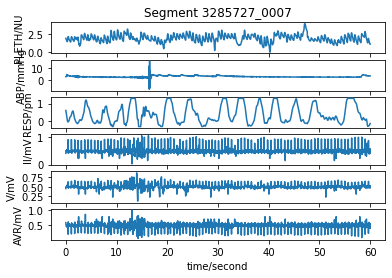

In [210]:
title_text = f"Segment {rel_segment_name}"
wfdb.plot_wfdb(record=segment_data,
               title=title_text,
               time_units='seconds') 

- Extract the PPG signal to loook at it more closely

In [211]:
for sig_no in range(0, len(segment_data.sig_name)):
    if "PLETH" in segment_data.sig_name[sig_no]:
        break

ppg = segment_data.p_signal[:, sig_no]
fs = segment_data.fs
print(f"Extracted the PPG signal from column {sig_no} of the matrix of waveform data.")

Extracted the PPG signal from column 0 of the matrix of waveform data.


<div class="alert alert-block alert-warning"><p><b>Note:</b> the name given to PPG signals in the database is 'PLETH'.</p></div>

- Plot to look at the shape of the PPG pulse wave more closely

(50.0, 55.0)

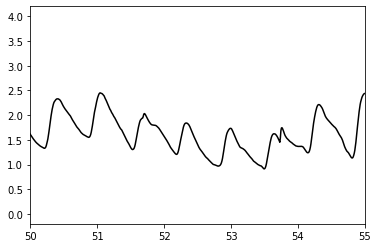

In [212]:
from matplotlib import pyplot as plt
import numpy as np

t = np.arange(0, (len(ppg) / fs), 1.0 / fs)
plt.plot(t, ppg, color = 'black', label='PPG')
plt.xlim([50, 55])

### Compare this to pulse waves from the literature

- Compare the pulse waves above to the different shapes of pulse waves shown here:

![PPG pulse waves](https://upload.wikimedia.org/wikipedia/commons/e/ed/Classes_of_photoplethysmogram_%28PPG%29_pulse_wave_shape.svg)

Source: _Charlton PH et al., 'Assessing hemodynamics from the photoplethysmogram to gain insights into vascular age: a review from VascAgeNet', https://doi.org/10.1152/ajpheart.00392.2021 (CC BY 4.0)_

These pulse waves are the typical shapes for young (class 1) to old (class 4) subjects.

<div class="alert alert-block alert-info"><p><b>Question:</b> How do these pulse waves compare to those extracted from the MIMIC Database? Which is most similar?</p></div>